# COIN-OR

In [1]:
# Datenzugriff
from configs.path_manager import get_path
import json

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.lp import makespan

# conda install -c conda-forge highs

In [2]:
max_time = 60*60*2 # 60 min

logs_path = get_path("data", "logs")

In [3]:
# Datei laden
basic_data_path = get_path("data", "basic")
file_path = basic_data_path / "jobshop_instances.json"

with open(file_path, "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)

df_production_orders = init.production_orders(df_instance)
df_production_orders

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
...,...,...,...,...,...
95,9,9,5,M09,76
96,9,9,6,M05,47
97,9,9,7,M03,52
98,9,9,8,M04,90


### a) CBC - COIN-OR Branch and Cut

In [14]:
log_file_path = logs_path / "makespan_cbc.log"

# Scheduling
df_schedule = makespan.solve_jssp(df_production_orders, solver= "CBC", msg=False, time_limit=max_time,logPath=log_file_path)
df_schedule

BigM: 5200

Solver-Informationen:
  Zielfunktionswert       : 955.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 551
  Anzahl Constraints      : 1090
  Laufzeit                : ~7201.41 Sekunden


,Job,Operation,Machine,Start,Processing Time,End
0,3,0,M01,0.0,81,81.0
1,5,0,M02,0.0,84,84.0
2,8,0,M00,0.0,76,76.0
3,1,0,M00,76.0,43,119.0
4,4,0,M02,84.0,14,98.0
...,...,...,...,...,...,...
95,5,8,M04,915.0,6,921.0
96,0,9,M09,919.0,21,940.0
97,1,9,M08,919.0,30,949.0
98,2,9,M04,921.0,33,954.0


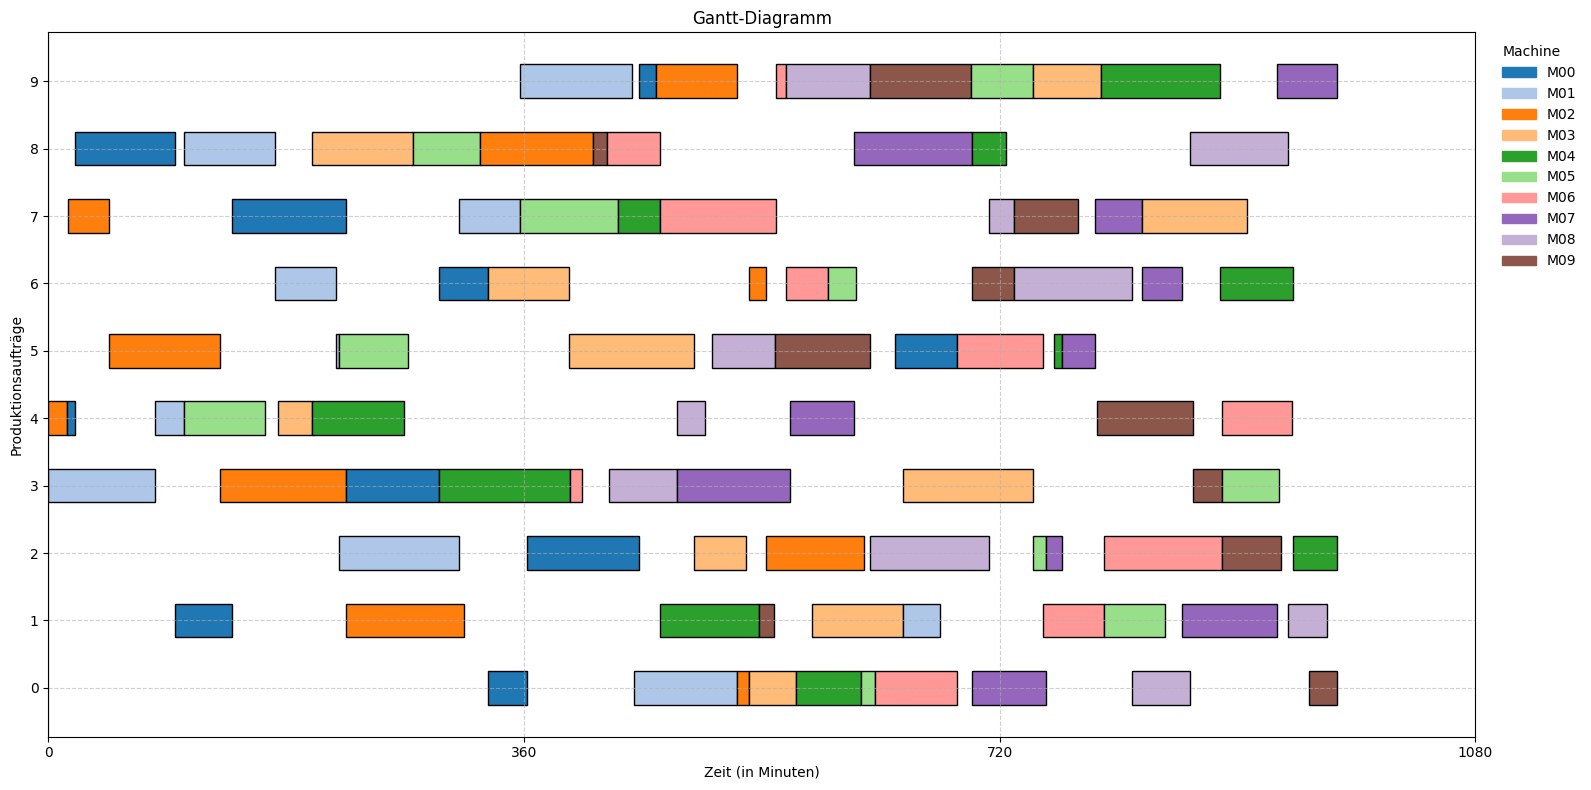

In [6]:
show.plot_gantt(df_schedule, perspective="Job")

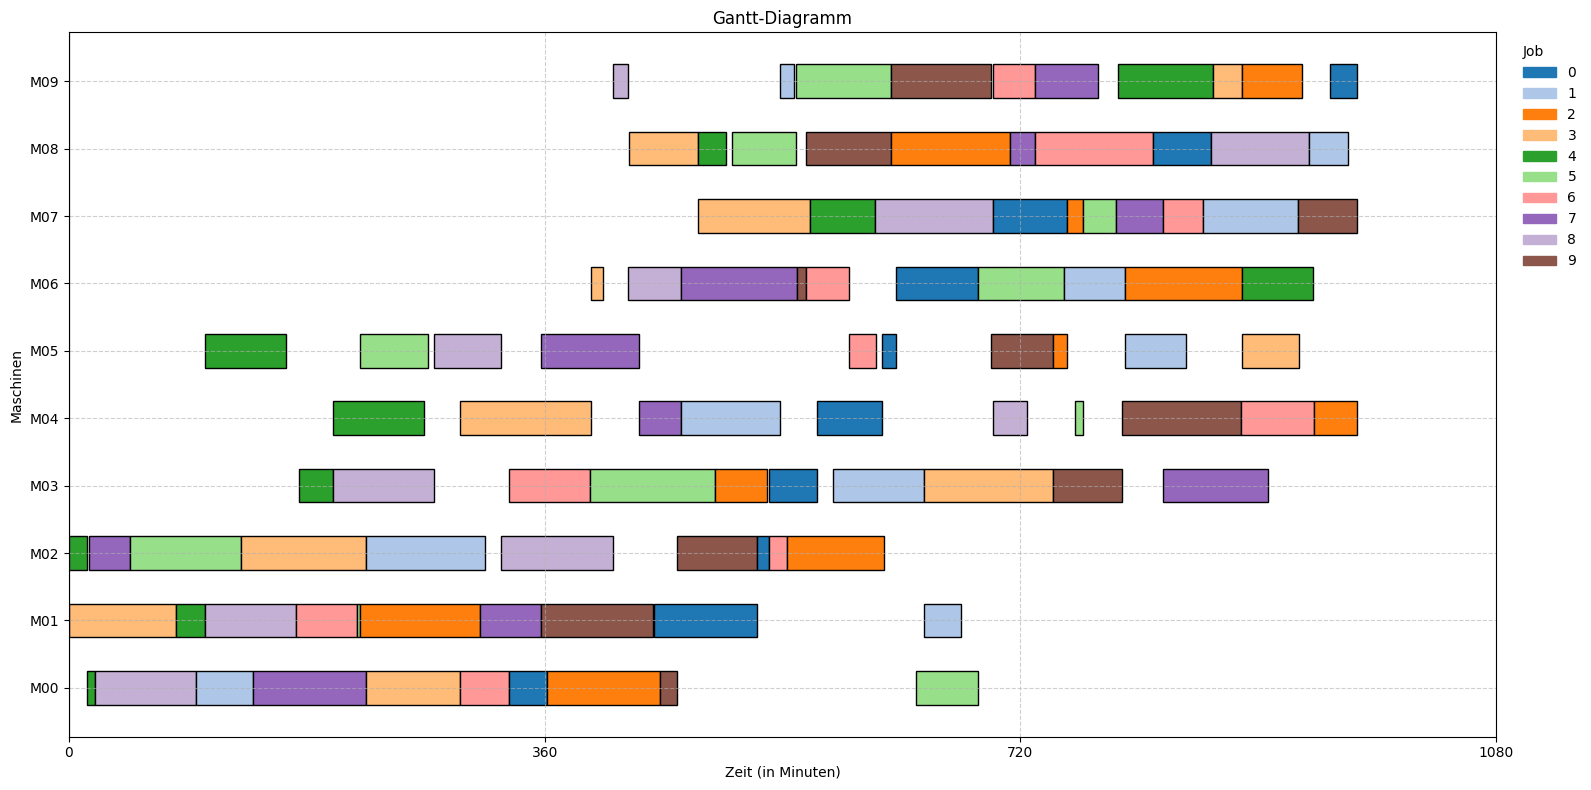

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.


True

In [7]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)

In [ ]:
-

### b) HiGHS mit PuLP

> high performance serial and parallel solver

In [ ]:
log_file_path = logs_path / "makespan_highs.log"

# Scheduling
df_schedule = makespan.solve_jssp(df_production_orders, solver= "HiGHS", msg=True, var_cat="Integer", time_limit=max_time, logPath=log_file_path)
df_schedule

BigM: 5200


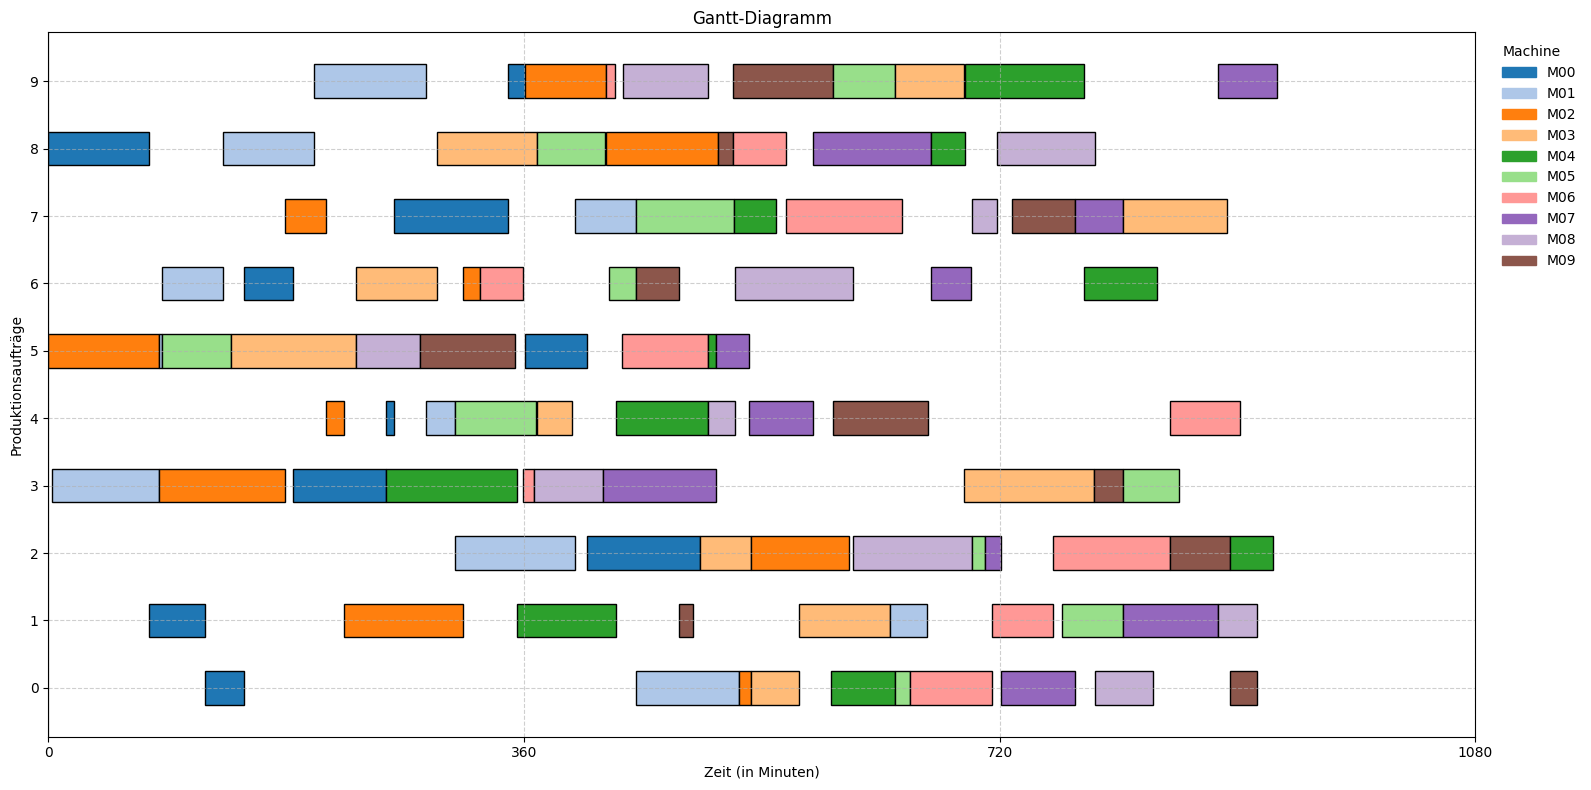

In [9]:
show.plot_gantt(df_schedule, perspective="Job")

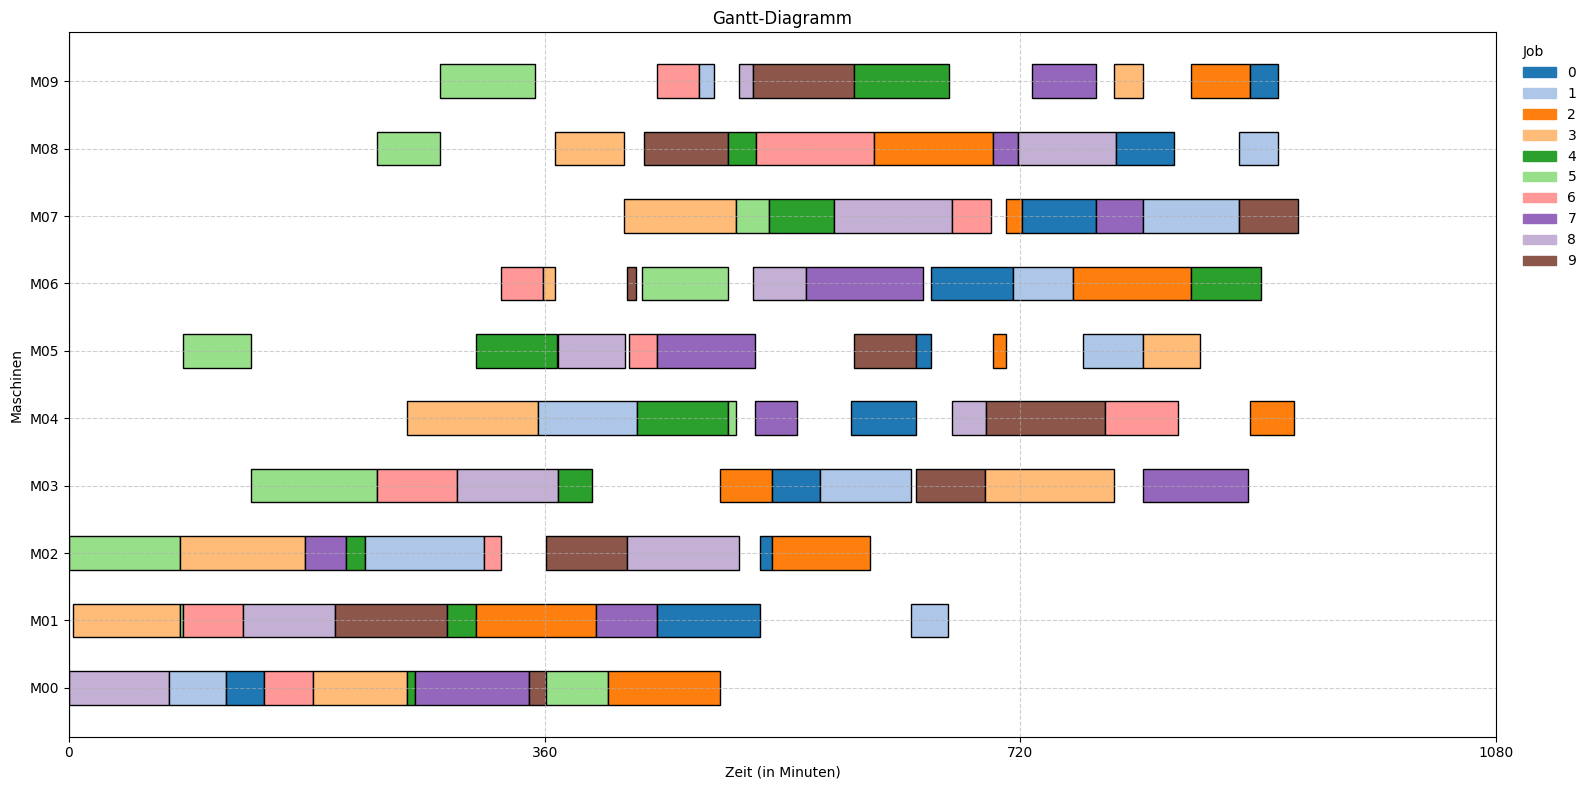

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.


True

In [10]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)